<font color='blue'> **27. Delay Interbed Drainage** </font> Problem 01-02 SUB

In [1]:
import os ; from pathlib import Path  ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles   
from modflow_devtools.misc import get_env ; write = get_env("WRITE", True) ; run = get_env("RUN", True)
from flopy.utils.postprocessing import get_water_table ; import pandas as pd
sim_name = "ex-gwf-csub-p02" ; workspace = Path("./27")      ; workspace.mkdir(exist_ok=True)    ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  

In [2]:
length_units = "meters" ; time_units = "days" ; nlay = 1 ;ncol = 3 ;nrow = 1 ;delr = 1 ;delc = 1 ;top = 0 ;botm = -1000 ; strt = 0 ;icelltype = 0  
nper           = 1 ; tdis_ds = ((1000.0, 100, 1.05),)  
nouter = 1000 ; ninner = 300 ; hclose = 0.000000001 ; rclose = 0.000001 ; linaccel = "bicgstab" ; relax = 0.97  ; k11 = 1000000     # kv x k11 (m/d) 
sgm = 1.7  ;sgs = 2.0  ;tau0 = 1000.0  ;cg_theta = 0.2  ;ske = 1.0e-5  ;skv = 1.0e-2  ;theta= 0.45  ;h0= 1.0  ;head_offset = 1.0     ;c6 = []
for j in range(0, ncol, 2):     c6.append([0, 0, j, strt])

c6_CHD [[0, 0, 0, 0], [0, 0, 2, 0]]


(-0.5, 944.5, 386.5, -0.5)

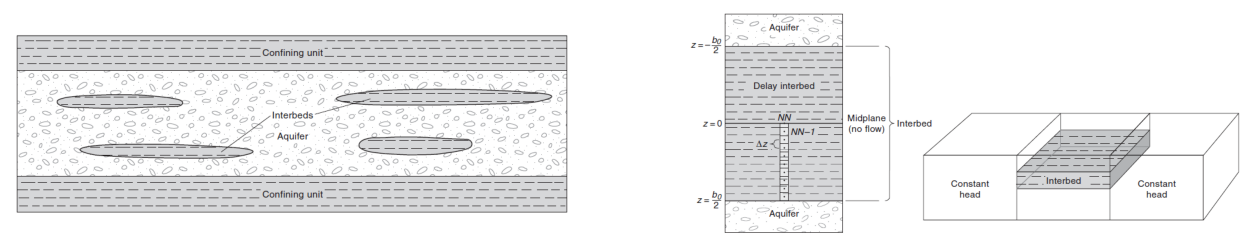

In [3]:
fig = plt.figure(figsize=(16, 12)) ; print('c6_CHD', c6) ; np.savetxt(workspace / "02_c6_CHD.csv", c6, delimiter=",")
ax = fig.add_subplot(121) ;image=plt.imread('E:/15_REPOS/00_BETAMI/bin/Flopy_3099/Fig/PDF_fig_27_SUB_2.PNG') ;ax.imshow(image) ;ax.axis('off')
ax = fig.add_subplot(122) ;image=plt.imread('E:/15_REPOS/00_BETAMI/bin/Flopy_3099/Fig/PDF_fig_27_SUB_1.PNG') ;ax.imshow(image) ;ax.axis('off')

In [4]:
%%capture
parameters = {"ex-gwf-csub-p02a": {"head_based": True ,"bed_thickness": (1.0,),                                   "kv": (2.5e-06,),"ndelaycells": 19},
              "ex-gwf-csub-p02b": {"head_based": False,"bed_thickness": (1.0,),                                   "kv": (2.5e-06,),"ndelaycells": 19},
              "ex-gwf-csub-p02c": {"head_based": True ,"bed_thickness": (1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0), "kv": 
                                                      (2.5e-06, 1e-05, 6.25e-05, 0.00025, 0.001, 0.00625, 0.025)                ,"ndelaycells": 1001}}
def build_models(name ,subdir_name =".", head_based=True ,bed_thickness=1.0 ,kv=2e-6 ,ndelaycells=19,):
    if head_based:    hb_bool = True ; pc0 =  head_offset ; tsgm = None ; tsgs = None
    else:             hb_bool = None ; pc0 = -head_offset ; tsgm = sgm  ; tsgs = sgs
    sub6 = [[0 ,0 ,0 ,1 ,"delay" ,pc0 ,bed_thickness ,1.0 ,skv ,ske ,theta ,kv ,h0 ,"ib1"]]

    opth = f"{name}.csub.obs" ; csub_csv=opth+".csv"
    obs =  [("tcomp" ,"interbed-compaction" ,(0 ,)) ,("sk" ,"sk" ,(0 ,)) ,("qtop" ,"delay-flowtop" ,(0,)) ,("qbot" ,"delay-flowbot" ,(0,))]
    for k in range(ndelaycells): tag = f"H{k + 1:04d}" ; obs.append((tag, "delay-head", (0,), (k,)))
    if not head_based:
        iposm = int(ndelaycells / 2) + 1 ; iposb = ndelaycells - 1
        obs += [("est", "delay-estress", (0,), (0,))     ,("esm", "delay-estress", (0,)     , (iposm,)),
                ("esb", "delay-estress", (0,), (iposb,)) ,("gs", "gstress-cell", (0, 0, 1)) ,("es", "estress-cell", (0, 0, 1))]
    orecarray = {csub_csv: obs}   ; head_filerecord=f"{sim_name}.hds" ; budget_filerecord=f"{sim_name}.cbc"
    
    sim_ws = os.path.join(workspace, name)
    if subdir_name is not None: sim_ws = os.path.join(sim_ws, subdir_name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms    (sim,outer_maximum=nouter,outer_dvclose=hclose,linear_acceleration=linaccel,inner_maximum=ninner,inner_dvclose=hclose,
                             relaxation_factor=relax,rcloserecord=f"{rclose} strict") 
    gwf = flopy.mf6.ModflowGwf  (sim, modelname=name, save_flows=True, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis (gwf ,length_units=length_units ,nlay=nlay ,nrow=nrow ,ncol=ncol ,delr=delr ,delc=delc ,top=top ,botm=botm)
    flopy.mf6.ModflowUtlobs (gwf ,digits=10 ,print_input=True ,continuous={"gwf_obs.csv":[("h1_1_2" ,"HEAD" ,(0 ,0 ,1))]})
    flopy.mf6.ModflowGwfic  (gwf ,strt=strt)
    flopy.mf6.ModflowGwfnpf (gwf ,icelltype=icelltype ,k=k11 ,save_specific_discharge=True ,)
    flopy.mf6.ModflowGwfsto (gwf ,iconvert=icelltype ,ss=0.0 ,sy=0 ,transient={0:True})
    csub = flopy.mf6.ModflowGwfcsub (gwf ,print_input=True ,save_flows=True ,head_based=hb_bool ,ndelaycells=ndelaycells ,boundnames=True ,ninterbeds=1, 
                                     sgm=tsgm ,sgs=tsgs ,cg_theta=cg_theta ,cg_ske_cr=0.0 ,beta=0.0 ,packagedata=sub6)  
    csub.obs.initialize(filename=opth, digits=10, print_input=True, continuous=orecarray)
    flopy.mf6.ModflowGwfchd (gwf, stress_period_data={0: c6})
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
def run_models  (sim, silent=True): success, buff = sim.run_simulation(silent=silent)  ;     assert success, buff
def scenarios(idx, silent=True):
    key = list(parameters.keys())[idx]   ; interbed_thickness = parameters[key]["bed_thickness"] ; 
    interbed_kv = parameters[key]["kv"]  ; params = parameters[key].copy()
    if len(interbed_thickness) == 1:
        params["bed_thickness"] = interbed_thickness[0]  ; params["kv"] = interbed_kv[0]   ; sim = build_models(key, **params)
        if write: write_models (sim, silent=silent)
        if run:   run_models   (sim, silent=silent)
    else:
        for b, kv in zip(interbed_thickness, interbed_kv):
            for head_based in (True, False):
                if head_based:     subdir_name = "hb-"
                else:              subdir_name = "es-"
                subdir_name += f"{int(b):03d}"  ; params["head_based"] = head_based ; params["bed_thickness"] = b ; params["kv"] = kv
                sim = build_models(key, subdir_name=subdir_name, **params)
                if write: write_models(sim, silent=silent)
                if run:   run_models(sim, silent=silent)
scenarios(0) ; scenarios(1); scenarios(2)

In [5]:
name = list(parameters.keys())[0]     ; sim_ws0 = Path(workspace, name)       ; sim  = flopy.mf6.MFSimulation().load(sim_ws=sim_ws0, verbosity_level=0)
gwf = sim.get_model(name)             ; head = gwf.output.head().get_data()   ; what=get_water_table(head) 
cobs = gwf.csub.output.obs().data     ; tpct = cobs["totim"] * 100 / tau0   # ; arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)

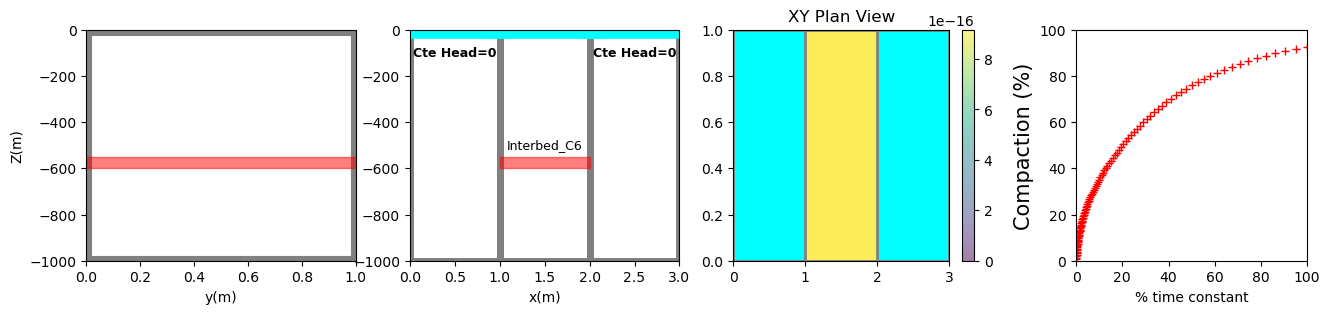

In [6]:
fig = plt.figure(figsize=(16, 3))        
ax = fig.add_subplot(141) ; pxx = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": 0}) ; pxx.plot_grid(linewidth=8) ; ax.set_xlabel("y(m)")
ax.set_ylabel("Z(m)")     ; ax.fill_between([0 ,1] ,y1=-600 ,y2=-550 ,color="red" ,alpha=0.5)                
ax = fig.add_subplot(142) ; pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})    ; pxs.plot_grid(linewidth=5) ; ax.set_xlabel("x(m)")

styles.add_text(ax=ax  ,text="Cte Head=0" ,x=0.5 ,y=-100 ,bold=True , italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
styles.add_text(ax=ax  ,text="Cte Head=0" ,x=2.5 ,y=-100 ,bold=True , italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
styles.add_text(ax=ax  ,text="Interbed_C6",x=1.5 ,y=-500 ,bold=False, italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
ax.fill_between([1 ,2] ,y1=-600 ,y2=-550 ,color="red" ,alpha=0.5)   ; pxs.plot_surface(what, masked_values=[1e30], color="cyan", lw=12) 
ax = fig.add_subplot(143)  ; pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)      ; ax.set_title('XY Plan View') 
pmv.plot_grid(linewidth=2) ; cb = pmv.plot_array(head, alpha=0.5) ; cb = plt.colorbar(cb) ; pmv.plot_bc("CHD", plotAll=True,color="cyan")

ax = fig.add_subplot(144, aspect="equal")                    ; ax.plot(tpct,100 * cobs["TCOMP"] / skv, marker="+",lw=0.05,ms=6,color="red" , label='MOD') 
ax.set_xlabel("% time constant")      ; ax.set_xlim(0, 100)          ; ax.set_ylim(0, 100)   ; ax.set_ylabel("Compaction (%)" ,fontsize=15)  #; plt.show()
#ax.plot(tpct,100 * cc1/ skv,label="Analitical x Simulated",color="yellow", lw=1)          ; leg = styles.graph_legend(ax, loc="lower right"); plt.show()
th=pd.DataFrame(cobs)  ; th.to_csv (workspace / '01a_cobs.csv')              ; # np.savetxt(workspace / "02_cc1.csv", cc1, delimiter=",")    # tpct | cobs
plt.show() 

<font color='blue'> **Part II** </font>

In [7]:
name = list(parameters.keys())[1]     ; sim_ws0 = Path(workspace, name)       ; sim  = flopy.mf6.MFSimulation().load(sim_ws=sim_ws0, verbosity_level=0)
gwf = sim.get_model(name)             ; head = gwf.output.head().get_data()    
cobs1 = gwf.csub.output.obs().data    ; tpct1 = cobs1["totim"] * 100 / tau0   # ; arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)

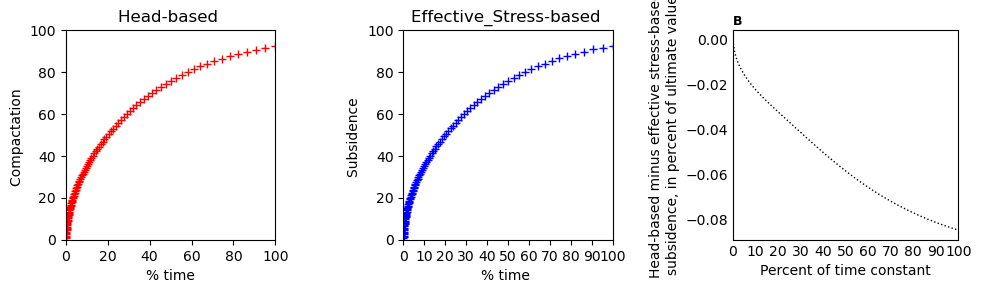

In [8]:
fig = plt.figure(figsize=(10, 3))        

ax = fig.add_subplot(131, aspect="equal")   ; ax.plot(tpct ,100 * cobs["TCOMP"]  / skv, marker="+",lw=0.05,ms=6,color="red") ;ax.set_xlabel("% time")
ax.set_xlim(0, 100)  ; ax.set_ylim(0, 100)  ; ax.set_title("Head-based " , fontsize=12) ; ax.set_ylabel("Compactation ")

ax = fig.add_subplot(132, aspect="equal")   ; ax.plot(tpct,100 * cobs1["TCOMP"] / skv, marker="+",lw=0.05,ms=6,color="blue") ;ax.set_xlabel("% time ")
ax.set_xlim(0, 100)  ; ax.set_ylim(0, 100)  ; ax.set_title("Effective_Stress-based " , fontsize=12)  ; ax.set_ylabel("Subsidence ")
th=pd.DataFrame(cobs1)  ; th.to_csv (workspace / '01b_cobs1.csv')       ; ax.set_xticks(np.arange(0, 110, 10))               

ax = fig.add_subplot(133)  
ax.plot(tpct,100 * (cobs["TCOMP"] - cobs1["TCOMP"]) / skv,lw=1,ls=":",color="black")  ; ax.set_xticks(np.arange(0, 110, 10))
ax.set_xlabel("Percent of time constant") ; ax.set_ylabel("Head-based minus effective stress-based\nsubsidence, in percent of ultimate value")
ax.set_xlim(0, 100) ; styles.heading(ax, letter="B") ; styles.remove_edge_ticks(ax) ; plt.tight_layout() ; plt.show()

<font color='blue'> **Part III** </font> 

In [9]:
name = list(parameters.keys())[2]
def get_subdirs(sim):
    name = list(parameters.keys())[2] 
    pth = os.path.join(workspace, name)
    hb_dirs = [name for name in sorted(os.listdir(pth)) if os.path.isdir(os.path.join(pth, name)) and name.startswith("hb-")]
    es_dirs = [name for name in sorted(os.listdir(pth)) if os.path.isdir(os.path.join(pth, name)) and name.startswith("es-")]
    return hb_dirs, es_dirs
hb_dirs, es_dirs = get_subdirs(sim)

In [10]:
sim_ws0 = os.path.join(workspace, name, hb_dirs[0])                  ; sim0   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws0, verbosity_level=0) ; 
sim_ws1 = os.path.join(workspace, name, hb_dirs[1])                  ; sim1   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws1, verbosity_level=0) ; 
sim_ws2 = os.path.join(workspace, name, hb_dirs[2])                  ; sim2   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws2, verbosity_level=0) ; 
sim_ws3 = os.path.join(workspace, name, hb_dirs[3])                  ; sim3   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws3, verbosity_level=0) ; 
sim_ws4 = os.path.join(workspace, name, hb_dirs[4])                  ; sim4   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws4, verbosity_level=0) ; 
sim_ws5 = os.path.join(workspace, name, hb_dirs[5])                  ; sim5   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws5, verbosity_level=0) ; 
sim_ws6 = os.path.join(workspace, name, hb_dirs[6])                  ; sim6   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws6, verbosity_level=0) ; 

gwf0 = sim0.get_model(name) ; h_cobs0 = gwf0.csub.output.obs().data  ; T_COMP0 = h_cobs0["TCOMP"] ; th0=pd.DataFrame(T_COMP0)
gwf1 = sim1.get_model(name) ; h_cobs1 = gwf1.csub.output.obs().data  ; T_COMP1 = h_cobs1["TCOMP"] ; th1=pd.DataFrame(T_COMP1)
gwf2 = sim2.get_model(name) ; h_cobs2 = gwf2.csub.output.obs().data  ; T_COMP2 = h_cobs2["TCOMP"] ; th2=pd.DataFrame(T_COMP2)
gwf3 = sim3.get_model(name) ; h_cobs3 = gwf3.csub.output.obs().data  ; T_COMP3 = h_cobs3["TCOMP"] ; th3=pd.DataFrame(T_COMP3) 
gwf4 = sim4.get_model(name) ; h_cobs4 = gwf4.csub.output.obs().data  ; T_COMP4 = h_cobs4["TCOMP"] ; th4=pd.DataFrame(T_COMP4)
gwf5 = sim5.get_model(name) ; h_cobs5 = gwf5.csub.output.obs().data  ; T_COMP5 = h_cobs5["TCOMP"] ; th5=pd.DataFrame(T_COMP5)
gwf6 = sim6.get_model(name) ; h_cobs6 = gwf6.csub.output.obs().data  ; T_COMP6 = h_cobs6["TCOMP"] ; th6=pd.DataFrame(T_COMP6)  ; tpct_ref=pd.DataFrame(tpct)
df = pd.concat([tpct_ref[:], th0[:], th1[:], th2[:], th3[:], th4[:], th5[:], th6[:]], axis=1) ; df.columns=['1','2','3','4','5','6','7','8']
df.set_index('1', inplace=True, drop=True) ; df_hb_dirs = df.rename(columns = lambda x : 'a' + str(x))  ; df_hb_dirs.to_csv (workspace / '04a_hb_dirs.csv')

In [11]:
sim_ws0 = os.path.join(workspace, name, es_dirs[0])                  ; sim0   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws0, verbosity_level=0) ; 
sim_ws1 = os.path.join(workspace, name, es_dirs[1])                  ; sim1   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws1, verbosity_level=0) ; 
sim_ws2 = os.path.join(workspace, name, es_dirs[2])                  ; sim2   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws2, verbosity_level=0) ; 
sim_ws3 = os.path.join(workspace, name, es_dirs[3])                  ; sim3   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws3, verbosity_level=0) ; 
sim_ws4 = os.path.join(workspace, name, es_dirs[4])                  ; sim4   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws4, verbosity_level=0) ; 
sim_ws5 = os.path.join(workspace, name, es_dirs[5])                  ; sim5   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws5, verbosity_level=0) ; 
sim_ws6 = os.path.join(workspace, name, es_dirs[6])                  ; sim6   = flopy.mf6.MFSimulation().load(sim_ws=sim_ws6, verbosity_level=0) ; 

gwf0 = sim0.get_model(name) ; e_cobs0 = gwf0.csub.output.obs().data  ; ES0 = e_cobs0["TCOMP"] ; th0=pd.DataFrame(ES0)
gwf1 = sim1.get_model(name) ; e_cobs1 = gwf1.csub.output.obs().data  ; ES1 = e_cobs1["TCOMP"] ; th1=pd.DataFrame(ES1)
gwf2 = sim2.get_model(name) ; e_cobs2 = gwf2.csub.output.obs().data  ; ES2 = e_cobs2["TCOMP"] ; th2=pd.DataFrame(ES2)
gwf3 = sim3.get_model(name) ; e_cobs3 = gwf3.csub.output.obs().data  ; ES3 = e_cobs3["TCOMP"] ; th3=pd.DataFrame(ES3) 
gwf4 = sim4.get_model(name) ; e_cobs4 = gwf4.csub.output.obs().data  ; ES4 = e_cobs4["TCOMP"] ; th4=pd.DataFrame(ES4)
gwf5 = sim5.get_model(name) ; e_cobs5 = gwf5.csub.output.obs().data  ; ES5 = e_cobs5["TCOMP"] ; th5=pd.DataFrame(ES5)
gwf6 = sim6.get_model(name) ; e_cobs6 = gwf6.csub.output.obs().data  ; ES6 = e_cobs6["TCOMP"] ; th6=pd.DataFrame(ES6)
df = pd.concat([tpct_ref[:], th0[:], th1[:], th2[:], th3[:], th4[:], th5[:], th6[:]], axis=1)   ; df.columns=['1','2','3','4','5','6','7','8']
df.set_index('1', inplace=True, drop=True) ; df_es_dirs = df.rename(columns = lambda x : 'a' + str(x))  ; df_es_dirs.to_csv (workspace / '04b_es_dirs.csv')

In [12]:
df_result = (-df_es_dirs + df_hb_dirs) * 100 
df_result.rename(columns={'a2':'r1','a3':'r2','a4':'r5','a5':'r10','a6':'r20','a7':'r50','a8':'r100'}, inplace=True)  
df_result.to_csv (workspace / '06_r1.csv') 

In [13]:
df=pd.DataFrame(h_cobs0) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs0) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc0 = dfb / dfa  *100
df=pd.DataFrame(h_cobs1) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs1) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc1 = dfb / dfa  *100
df=pd.DataFrame(h_cobs2) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs2) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc2 = dfb / dfa  *100
df=pd.DataFrame(h_cobs3) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs3) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc3 = dfb / dfa  *100
df=pd.DataFrame(h_cobs4) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs4) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc4 = dfb / dfa  *100
df=pd.DataFrame(h_cobs5) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs5) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc5 = dfb / dfa  *100
df=pd.DataFrame(h_cobs6) ;df2 = df[["QTOP", "QBOT"]]   ; dfa = df2.sum(axis=1)       
df=pd.DataFrame(e_cobs6) ;df2 = df[["QTOP", "QBOT"]]   ; dfb = df2.iloc[:, 0] - df2.iloc[:, 1]  ; dfc6 = dfb / dfa  *100
df = pd.concat([tpct_ref[:],dfc0[:],dfc1[:],dfc2[:],dfc3[:],dfc4[:],dfc5[:],dfc6[:]],axis=1)    ; df.columns=['id','c0','c1','c2','c3','c4','c5','c6']
df.set_index('id', inplace=True, drop=True) ; sub = df

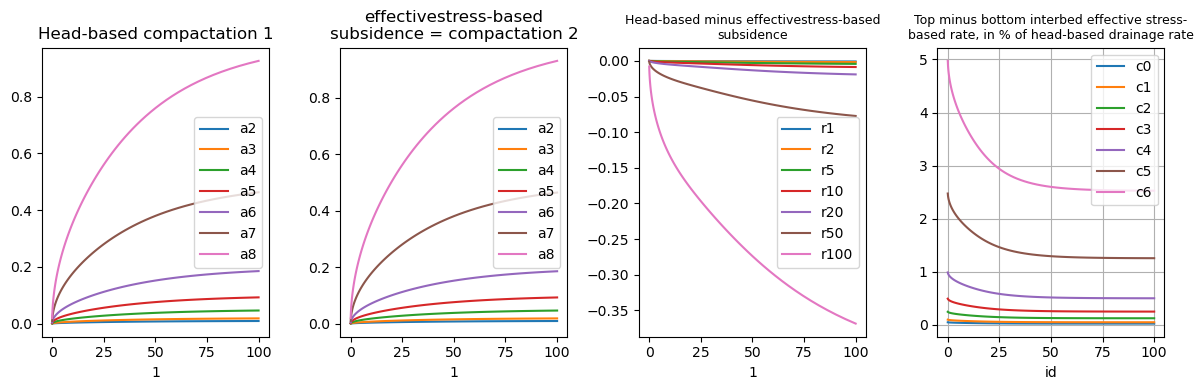

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=4)   
df_hb_dirs.plot(ax=ax[0] ,use_index=True, y=list(df_hb_dirs) , figsize=(12,4))     ; ax[0].set_title('Head-based compactation 1')
df_es_dirs.plot(ax=ax[1] ,use_index=True, y=list(df_hb_dirs) )   ; ax[1].set_title('effective''stress-based\nsubsidence = compactation 2')
df_result.plot (ax=ax[2] ,use_index=True, y=list(df_result)) ; plt.tight_layout() 
ax[2].set_title('Head-based minus effective''stress-based\nsubsidence', fontsize=9) ; sub.plot (ax=ax[3] ,use_index=True, y=list(sub))  
ax[3].set_title("Top minus bottom interbed effective stress-\nbased ""rate, in % of head-based drainage rate", fontsize=9 ) ; plt.grid() ; plt.show() 

In [15]:
def fill_heads(rec_arr, ndcells):     
    arr = np.zeros((rec_arr.shape[0], ndcells), dtype=float)
    for i in range(100):
        for j in range(ndcells):
            name = f"H{j + 1:04d}"   ;arr[i, j] = rec_arr[name][i]
    return arr
ndcells = parameters[name]["ndelaycells"]        ; print('ndcells', ndcells)    ;zaa = np.linspace(0, 1, ndcells)               # hhb hes
hb_arr = fill_heads(h_cobs0, ndcells) ;es_arr = fill_heads(e_cobs0, ndcells)    ;hhb=hb_arr[0,:] ;hes=es_arr[0, :]    ;va0=100.0*(hhb-hes)/hhb
hb_arr = fill_heads(h_cobs1, ndcells) ;es_arr = fill_heads(e_cobs1, ndcells)    ;hhb=hb_arr[1,:] ;hes=es_arr[1, :]    ;va1=100.0*(hhb-hes)/hhb
hb_arr = fill_heads(h_cobs2, ndcells) ;es_arr = fill_heads(e_cobs2, ndcells)    ;hhb=hb_arr[2,:] ;hes=es_arr[2, :]    ;va2=100.0*(hhb-hes)/hhb
hb_arr = fill_heads(h_cobs3, ndcells) ;es_arr = fill_heads(e_cobs3, ndcells)    ;hhb=hb_arr[3,:] ;hes=es_arr[3, :]    ;va3=100.0*(hhb-hes)/hhb
hb_arr = fill_heads(h_cobs4, ndcells) ;es_arr = fill_heads(e_cobs4, ndcells)    ;hhb=hb_arr[4,:] ;hes=es_arr[4, :]    ;va4=100.0*(hhb-hes)/hhb
hb_arr = fill_heads(h_cobs5, ndcells) ;es_arr = fill_heads(e_cobs5, ndcells)    ;hhb=hb_arr[5,:] ;hes=es_arr[5, :]    ;va5=100.0*(hhb-hes)/hhb
hb_arr = fill_heads(h_cobs6, ndcells) ;es_arr = fill_heads(e_cobs6, ndcells)    ;hhb=hb_arr[6,:] ;hes=es_arr[6, :]    ;va6=100.0*(hhb-hes)/hhb

ndcells 1001


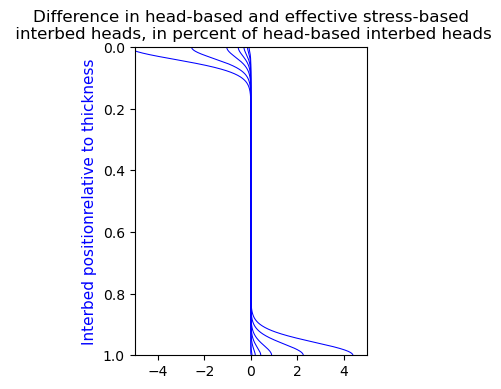

In [16]:
fig = plt.figure(figsize=(3, 4))         ; ax = fig.add_subplot(111)
ax.plot(va0, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5)
ax.plot(va1, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5) 
ax.plot(va2, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5) 
ax.plot(va3, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5) 
ax.plot(va4, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5) 
ax.plot(va5, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5) #; ax.yaxis.set_visible(False)
ax.plot(va6, zaa, lw=0.75, color='blue') ; ax.set_ylim(1, 0) ; ax.set_xlim(-5, 5)  
ax.set_ylabel('Interbed position' "relative to thickness", fontsize=11, color= 'blue')
ax.set_title("Difference in head-based and effective stress-based\n interbed heads, in percent of head-based interbed heads")
plt.show()

**There still remains something to be done in the figure above ...**
locs = {} ... # calculate location closest to 1, 5, 10, 50, and 100 percent of time constant